# Instalar as bibliotecas necessárias

In [1]:
!pip install torch torchvision scikit-learn numpy matplotlib

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# Geração dos Embeddings

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

model = models.resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])
model.eval()

embeddings = []
labels = []
print("Gerando embeddings...")
with torch.no_grad():
    for images, batch_labels in tqdm(dataloader):

        output = model(images)

        output = output.squeeze()
        embeddings.append(output.cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

np.save('embeddings.npy', embeddings)
np.save('labels.npy', labels)

print("Embeddings gerados e salvos com sucesso!")

images_list = []
for i in range(len(dataset)):
    images_list.append(dataset[i][0].numpy())
np.save('images.npy', np.array(images_list))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Gerando embeddings...


100%|██████████| 1875/1875 [02:53<00:00, 10.79it/s]


Embeddings gerados e salvos com sucesso!


# Sistema de Recomendação por Imagem

Total de imagens carregadas: 60000


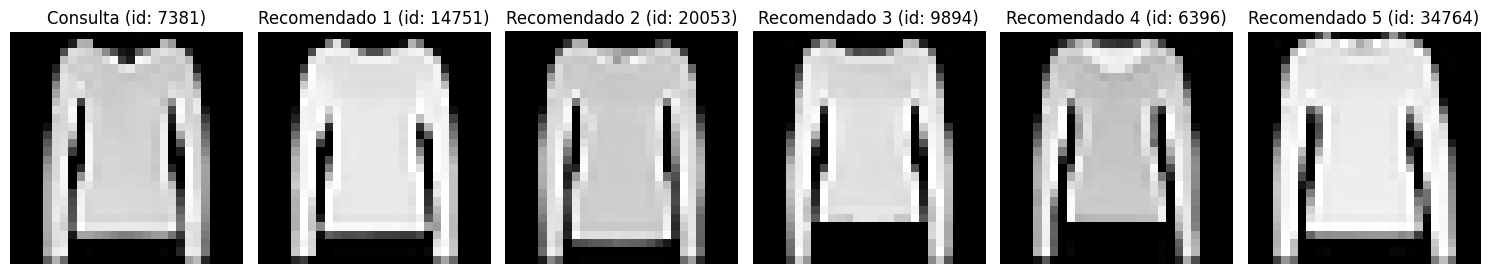

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision import transforms, datasets, utils
from PIL import Image
import matplotlib.pyplot as plt
import random

def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(img).unsqueeze(0)

def find_similar_items(query_embedding, embeddings, n_recommendations=5):
    similarities = cosine_similarity(query_embedding.reshape(1, -1), embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][1:n_recommendations + 1]
    return top_indices

embeddings = np.load('/content/embeddings.npy')
labels = np.load('/content/labels.npy')
images = np.load('/content/images.npy')

print(f"Total de imagens carregadas: {len(embeddings)}")

query_index = random.randint(0, len(embeddings) - 1)
query_embedding = embeddings[query_index]
query_image = images[query_index]

top_indices = find_similar_items(query_embedding, embeddings, n_recommendations=5)

fig, axes = plt.subplots(1, 6, figsize=(15, 3))

def visualize_image(image_data, mean, std):
    unnormalized_image = image_data.copy()
    for c in range(unnormalized_image.shape[0]):
        unnormalized_image[c, :, :] = unnormalized_image[c, :, :] * std[c] + mean[c]
    unnormalized_image = np.clip(unnormalized_image, 0, 1)
    return np.transpose(unnormalized_image, (1, 2, 0))


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

axes[0].imshow(visualize_image(query_image.copy(), mean, std)) # Use .copy() to avoid modifying the original array
axes[0].set_title(f"Consulta (id: {query_index})")
axes[0].axis('off')

for i, index in enumerate(top_indices):
    recommended_image = images[index]
    axes[i + 1].imshow(visualize_image(recommended_image.copy(), mean, std)) # Use .copy()
    axes[i + 1].set_title(f"Recomendado {i+1} (id: {index})")
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()